In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

#Helper function

In [2]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

#Gradient and Hessian of elastic energies

In [3]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dF : np.ndarray
        Derivative of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Gradient of bending energy
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k

    return dF


In [4]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b
    with respect to x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dJ : np.ndarray
        Hessian of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Compute the Hessian (second derivative of kappa)
    DDkappa1 = np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    Id3 = np.eye(3)

    # Helper matrices for second derivatives
    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    # Populate the Hessian of kappa
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    # Hessian of bending energy
    dkappa = kappa1 - kappaBar
    dJ = 1.0 / l_k * EI * np.outer(gradKappa, gradKappa)
    dJ += 1.0 / l_k * dkappa * EI * DDkappa1

    return dJ

In [5]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.

    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * EA * l_k * F  # Scale by EA and l_k

    return F


In [6]:
def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with
    respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * EA * l_k

    return J

# Functions to create elastic force vector and its Hessian

In [7]:
def getFs(q, EA, deltaL):
  # q - DOF vector of size N
  # EA - stretching stiffness
  # deltaL - undeformed reference length (assume to be a scalar for this simple example)
  # Output:
  # Fs - a vector (negative gradient of elastic stretching force)
  # Js - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fs = np.zeros(ndof) # stretching force
  Js = np.zeros((ndof, ndof))

  for k in range(0, N-1):
      # May need to modify if network of beams
      # k-th stretching spring (USE A LOOP for the general case
      xkm1 = q[2*k] # x coordinate of the first node
      ykm1 = q[2*k+1] # y coordinate of the first node
      xk = q[2*k+2] # x coordinate of the second node
      yk = q[2*k+3] # y coordinate of the second node
      ind = np.arange(2*k, 2*k+4) # 0, 1, 2, 3 for k = 0
      gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)
      hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)

      Fs[ind] -= gradEnergy # force = - gradient of energy. Fs is the stretching force
      Js[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:4

  return Fs, Js

In [8]:
def getFb(q, EI, deltaL):
  # q - DOF vector of size N
  # EI - bending stiffness
  # deltaL - undeformed Voronoi length (assume to be a scalar for this simple example)
  # Output:
  # Fb - a vector (negative gradient of elastic stretching force)
  # Jb - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fb = np.zeros(ndof) # bending force
  Jb = np.zeros((ndof, ndof))

  # First bending spring (USE A LOOP for the general case)
  for k in range(1, N-1):
    xkm1 = q[2*k-2] # x coordinate of the first node
    ykm1 = q[2*k-1] # y coordinate of the first node
    xk = q[2*k] # x coordinate of the second node
    yk = q[2*k+1] # y coordinate of the second node
    xkp1 = q[2*k+2] # x coordinate of the third node
    ykp1 = q[2*k+3] # y coordinate of the third node
    ind = np.arange(2*k-2, 2*k+4)
    gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)
    hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

    Fb[ind] -= gradEnergy # force = - gradient of energy. Fb is the stretching force
    Jb[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:6

  return Fb, Jb

# Objective Function or Integrator

Given the old position and the old velocity, find out th new position and the new velocity

In [9]:
def objfun(q_old, u_old, dt, tol, maximum_iter,
           m, mMat, # inertia
           EI, EA, # elastic stiffness
           W, C, # external force
           deltaL,
           free_index):

  q_new = q_old.copy() # Guess solution

  # Newton Raphson
  iter_count = 0 # number of iterations
  error = tol * 10 # error
  flag = 1 # if flag = 1, it is a good solution

  while error > tol:
    # Inertia
    F_inertia = m/dt * ((q_new - q_old) / dt - u_old)
    J_inertia = mMat / dt ** 2

    # Elastic forces: Stretching and Bending
    Fs, Js = getFs(q_new, EA, deltaL)
    Fb, Jb = getFb(q_new, EI, deltaL)
    F_elastic = Fs + Fb
    J_elastic = Js + Jb

    # External forces
    # Viscous force
    Fv = - C @ ( q_new - q_old ) / dt
    Jv = - C / dt

    # Equations of motion
    f = F_inertia - F_elastic - Fv - W
    J = J_inertia - J_elastic - Jv

    f_free = f[free_index]
    J_free = J[np.ix_(free_index, free_index)]

    # Newton's update (all DOFs are FREE)
    dq_free = np.linalg.solve(J_free, f_free)
    q_new[free_index] = q_new[free_index] - dq_free

    # Get the error
    error = np.linalg.norm(f_free)

    # Update the iteration number
    iter_count += 1
    if iter_count > maximum_iter:
      flag = -1 # Return with an error signal
      print("Maximum number of iterations reached.")
      return q_new, flag

    # u_new = (q_new - q_old) / dt # Velocity
  return q_new, flag


# Main

In [10]:
# Beam parameters from the problem
nv = 50  # number of nodes/vertices as requested
ndof = 2 * nv

# Time step
dt = 0.01  # second (as requested)

# Beam parameters from the problem
RodLength = 1.0  # meter
outer_radius = 0.013  # m
inner_radius = 0.011  # m
force_location = 0.75  # m from left end
P = 2000.0  # N (point load)

# Material properties for aluminum
E = 70e9  # Pa (70 GPa)
rho_aluminum = 2700  # kg/m³
visc = 0.0  # No viscous drag as specified

# Discrete length / reference length
deltaL = RodLength / (nv - 1)

# Moment of inertia
I = (np.pi/4) * (outer_radius**4 - inner_radius**4)

# Cross sectional area for mass calculation
A = np.pi * (outer_radius**2 - inner_radius**2)

# Utility quantities
ne = nv - 1 # number of edges
EI = E * I
EA = E * A

# Tolerance
tol = EI / RodLength ** 2 * 1e-6

# Maximum number of iterations
maximum_iter = 1000

# Total time
totalTime = 1.0  # second

# Variables related to plotting
saveImage = 0
plotStep = 10  # Plot every 10 steps

# Geometry - straight beam
nodes = np.zeros((nv, 2))
for c in range(nv):
  nodes[c, 0] = c * deltaL # x-coordinate
  nodes[c, 1] = 0.0 # y-coordinate

# Mass calculation - Eq (1)
m_per_node = A * RodLength * rho_aluminum / (nv - 1)

m = np.zeros(2 * nv)
for k in range(0, nv):
  m[2*k] = m_per_node # mass of k-th node along x
  m[2*k + 1] = m_per_node # mass of k-th node along y
mMat = np.diag(m)

# External force - only point load P at specified location
# Find node closest to force application point
force_node = round(force_location / deltaL)
print(f"Force applied at node {force_node} (distance: {force_node * deltaL:.3f}m)")

W = np.zeros(2 * nv)
W[2*force_node + 1] = -P  # Negative for downward force

# No viscous damping as specified
C = np.zeros((2 * nv, 2 * nv))

# Initial conditions
q0 = np.zeros(2 * nv)
for c in range(nv):
  q0[2*c] = nodes[c, 0] # x coordinate
  q0[2*c+1] = nodes[c, 1] # y coordinate

u0 = np.zeros(2 * nv) # old velocity

Force applied at node 37 (distance: 0.755m)


**Boundary Conditions**

In this example, the boundary conditions do not change with time and, therefore, we can compute the free_index (corresponding to free DOFs) and fixed_index (corresponding to fixed DOFs) at $t=0$.

In [11]:
all_DOFs = np.arange(ndof) # Set of all DOFs
# First node constrained in both x and y (pinned)
# Last node constrained only in y (roller)
fixed_index = np.array([0, 1, 2*(nv-1) + 1])  # x1, y1, yN

# Free index
free_index = np.setdiff1d(all_DOFs, fixed_index) # All the DOFs are free except the fixed ones

**Time stepping loop**

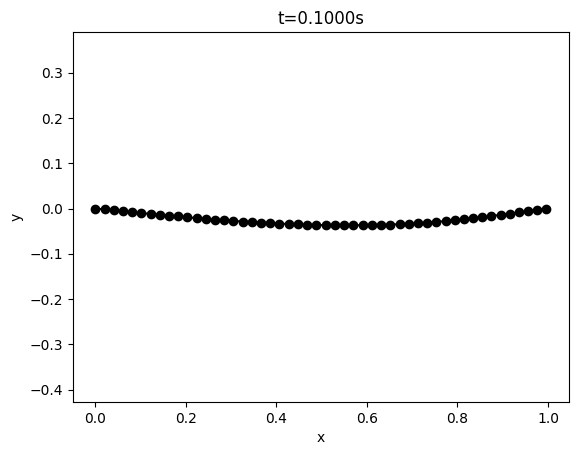

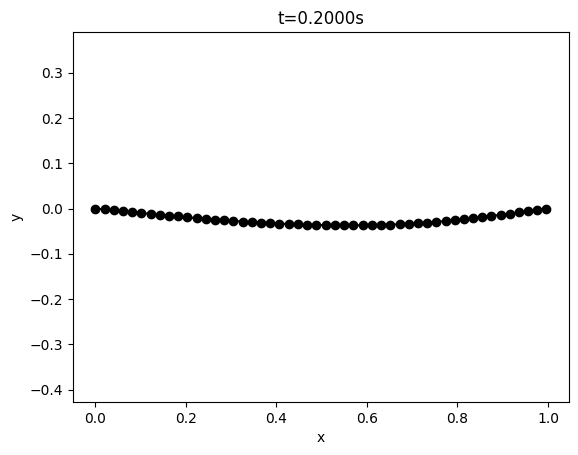

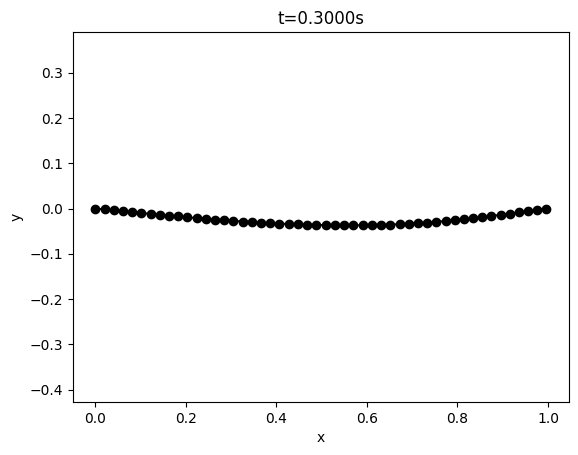

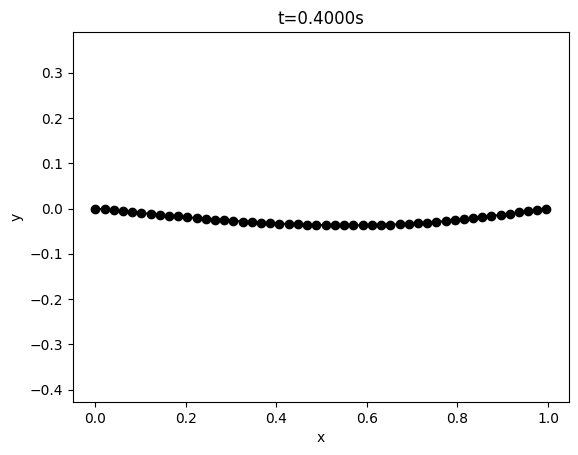

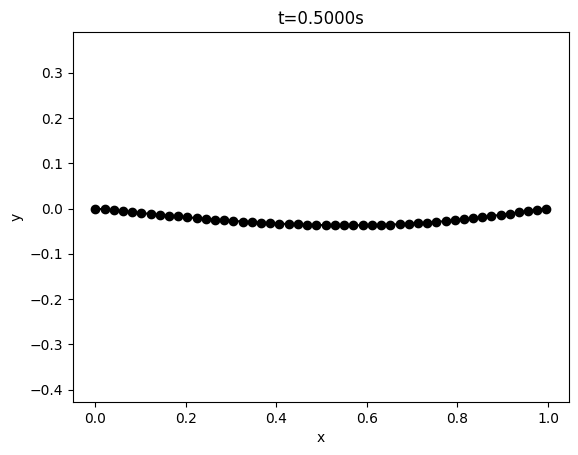

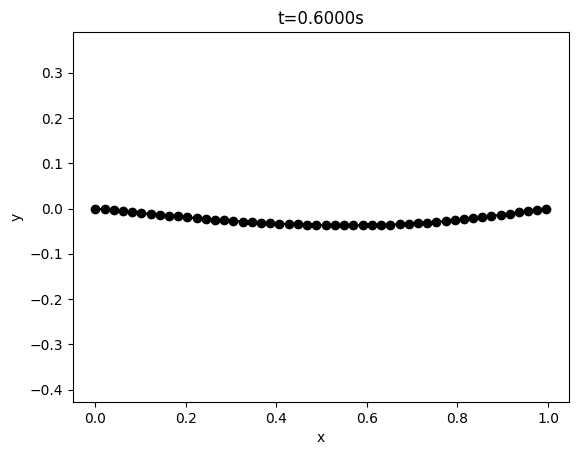

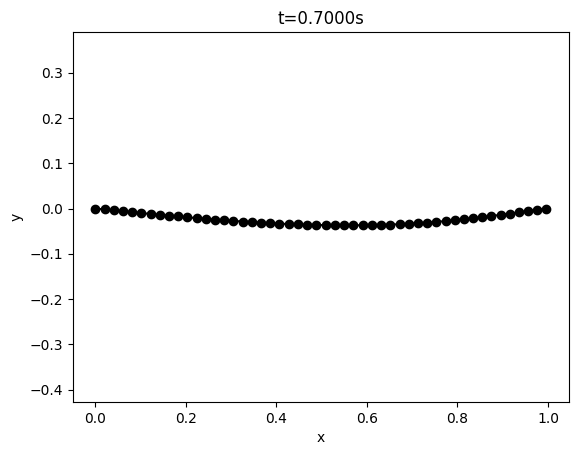

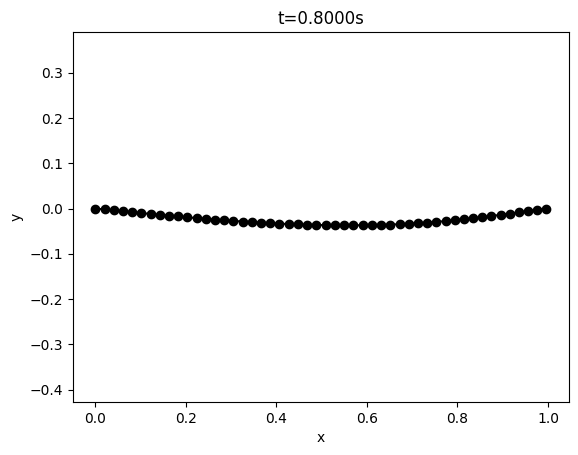

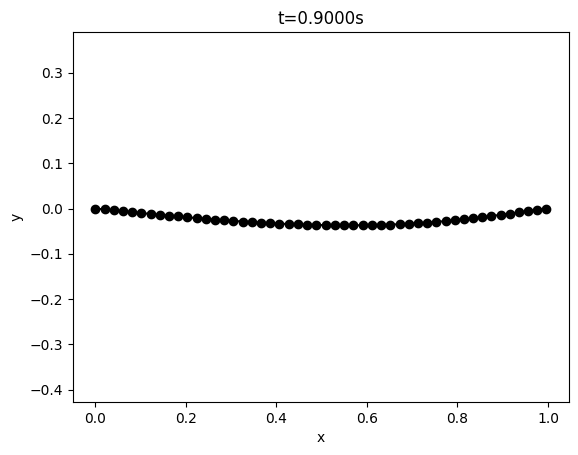

In [12]:
# Number of steps
Nsteps = round(totalTime / dt)

ctime = 0 # Current time

# Store the vertical displacements of all nodes over time
all_displacements = np.zeros((Nsteps, nv))
all_velocities = np.zeros((Nsteps, nv))

# Initialize
for c in range(nv):
    all_displacements[0, c] = 0
    all_velocities[0, c] = 0

# Loop over the time steps
for timeStep in range(1, Nsteps):
    q_new, error = objfun(q0, u0, dt, tol, maximum_iter, m, mMat, EI, EA, W, C,
                          deltaL, free_index)
    if error < 0:
        print('Could not converge.')
        break

    u_new = (q_new - q0) / dt # New velocity
    ctime += dt # Update current time

    # Save information about all nodes
    for c in range(nv):
        all_displacements[timeStep, c] = q_new[2*c+1] # y coordinate
        all_velocities[timeStep, c] = u_new[2*c+1] # y velocity

    q0 = q_new.copy() # New position becomes old position
    u0 = u_new.copy() # New velocity becomes old velocity

    # Plot
    if timeStep % plotStep == 0:
        x_arr = q_new[::2] # q[0], q[2], q[4]
        y_arr = q_new[1::2] # q[1], q[3], q[5]

        h1 = plt.figure(1)
        plt.clf() # Clear current figure
        plt.plot(x_arr, y_arr, 'ko-')
        plt.title(f't={ctime:.4f}s')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axis('equal')
        plt.show()

Theoretical maximum deflection: 0.038045 m
Simulated maximum deflection: -0.037109 m


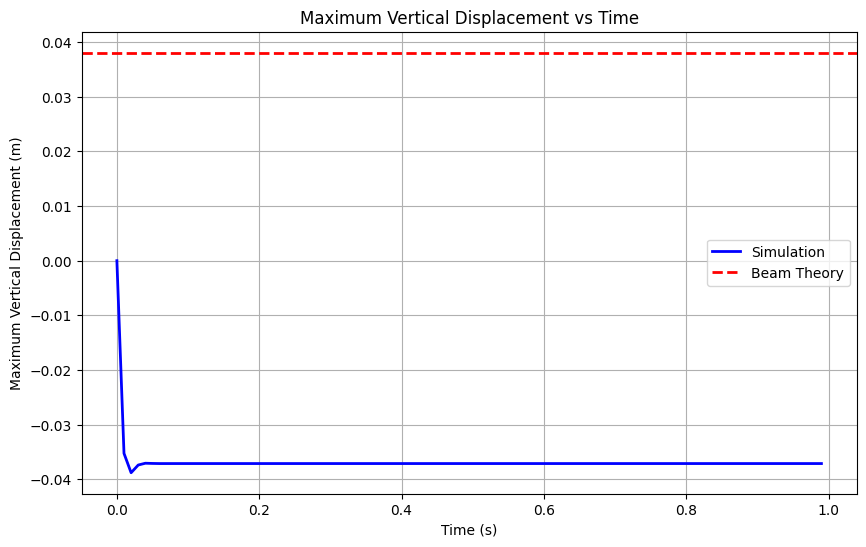

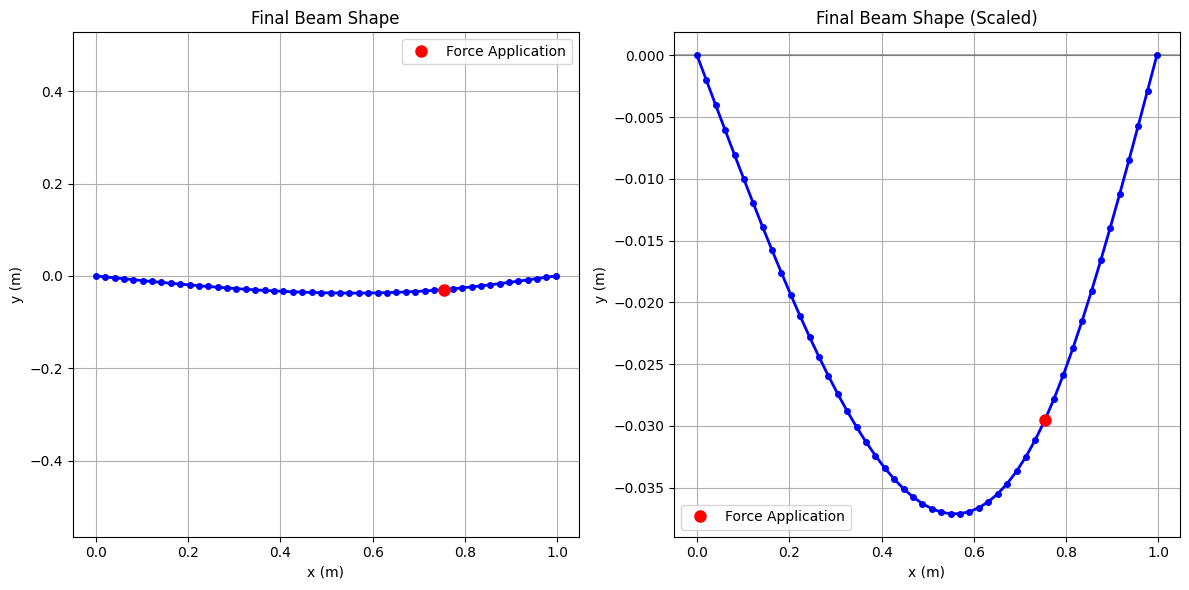


Beam Parameters:
Length: 1.0 m
Outer radius: 0.013 m
Inner radius: 0.011 m
Force P: 2000.0 N
Force location: 0.75 m from left end
EI: 7.65e+02 N·m²
Number of nodes: 50


In [13]:
# Analysis and comparison with beam theory
def beam_theory_deflection(P, E, I, l, d):
    """Calculate maximum deflection using Euler-Bernoulli beam theory"""
    c = min(d, l - d)
    y_max = (P * c * (l**2 - c**2)**1.5) / (9 * np.sqrt(3) * E * I * l)
    return y_max

# Theoretical prediction
theory_ymax = beam_theory_deflection(P, E, I, RodLength, force_location)
print(f"Theoretical maximum deflection: {theory_ymax:.6f} m")

# Get maximum deflection from simulation (most negative value)
simulation_ymax = np.min(all_displacements[-1, :])  # Last time step
print(f"Simulated maximum deflection: {simulation_ymax:.6f} m")
#print(f"Relative error: {abs((simulation_ymax - theory_ymax)/theory_ymax)*100:.2f}%")

# Plot maximum vertical displacement vs time
max_displacement_over_time = np.min(all_displacements, axis=1)  # Most negative at each time step

plt.figure(figsize=(10, 6))
plt.plot(np.arange(Nsteps) * dt, max_displacement_over_time, 'b-', linewidth=2, label='Simulation')
plt.axhline(y=theory_ymax, color='r', linestyle='--', linewidth=2, label='Beam Theory')
plt.xlabel('Time (s)')
plt.ylabel('Maximum Vertical Displacement (m)')
plt.title('Maximum Vertical Displacement vs Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot final beam shape
final_x = q_new[::2]
final_y = q_new[1::2]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(final_x, final_y, 'bo-', linewidth=2, markersize=4)
plt.plot([force_node * deltaL], [final_y[force_node]], 'ro', markersize=8, label='Force Application')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Final Beam Shape')
plt.axis('equal')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(final_x, final_y, 'bo-', linewidth=2, markersize=4)
plt.plot([force_node * deltaL], [final_y[force_node]], 'ro', markersize=8, label='Force Application')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Final Beam Shape (Scaled)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nBeam Parameters:")
print(f"Length: {RodLength} m")
print(f"Outer radius: {outer_radius} m")
print(f"Inner radius: {inner_radius} m")
print(f"Force P: {P} N")
print(f"Force location: {force_location} m from left end")
print(f"EI: {EI:.2e} N·m²")
print(f"Number of nodes: {nv}")






Running large deformation analysis...
Progress: 1/50 (P = 20.0 N)
Progress: 2/50 (P = 23.0 N)
Progress: 3/50 (P = 26.5 N)
Progress: 4/50 (P = 30.5 N)
Progress: 5/50 (P = 35.2 N)
Progress: 6/50 (P = 40.5 N)
Progress: 7/50 (P = 46.6 N)
Progress: 8/50 (P = 53.7 N)
Progress: 9/50 (P = 61.8 N)
Progress: 10/50 (P = 71.1 N)
Progress: 11/50 (P = 81.9 N)
Progress: 12/50 (P = 94.3 N)
Progress: 13/50 (P = 108.6 N)
Progress: 14/50 (P = 125.0 N)
Progress: 15/50 (P = 143.9 N)
Progress: 16/50 (P = 165.7 N)
Progress: 17/50 (P = 190.8 N)
Progress: 18/50 (P = 219.7 N)
Progress: 19/50 (P = 253.0 N)
Progress: 20/50 (P = 291.3 N)
Progress: 21/50 (P = 335.4 N)
Progress: 22/50 (P = 386.1 N)
Progress: 23/50 (P = 444.6 N)
Progress: 24/50 (P = 511.9 N)
Progress: 25/50 (P = 589.4 N)
Progress: 26/50 (P = 678.6 N)
Progress: 27/50 (P = 781.4 N)
Progress: 28/50 (P = 899.7 N)
Progress: 29/50 (P = 1035.9 N)
Progress: 30/50 (P = 1192.7 N)
Progress: 31/50 (P = 1373.3 N)
Progress: 32/50 (P = 1581.2 N)
Progress: 33/50 (P

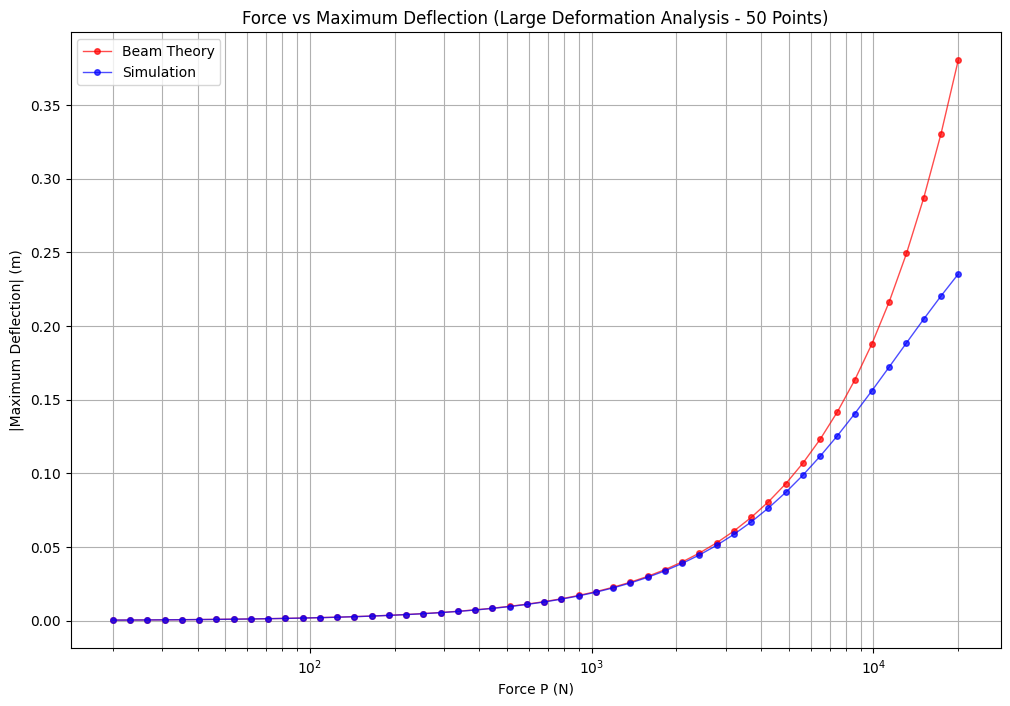


First significant divergence point found at P ≈ 7455 N
Relative error: 11.4%

Additional divergence points:
  P = 8584 N: 14.0% error
  P = 9883 N: 17.0% error
  P = 11380 N: 20.4% error
  P = 13103 N: 24.4% error
  P = 15086 N: 28.7% error
  ... and 2 more points


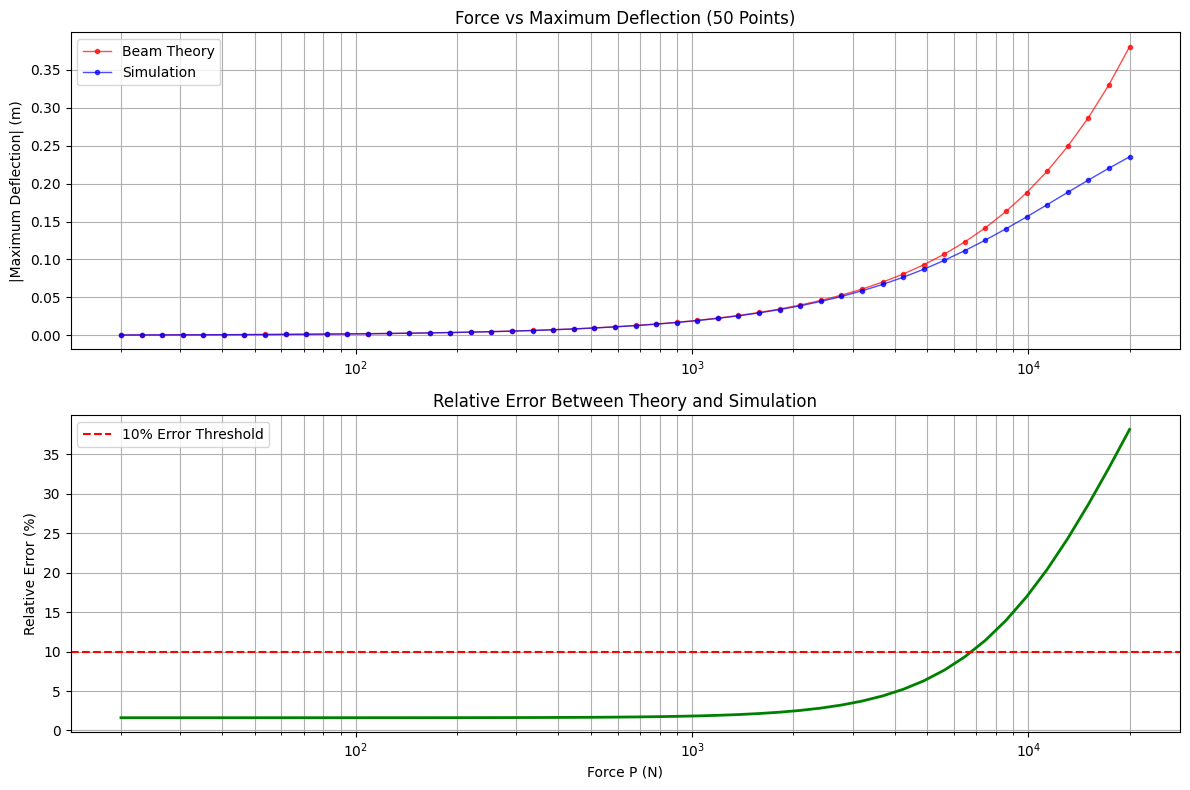


Summary Statistics:
Minimum P: 20.0 N, Maximum P: 20000.0 N
Range of theoretical deflections: 0.000380 to 0.380449 m
Range of simulated deflections: -0.235256 to -0.000374 m
Average relative error: 5.77%
Maximum relative error: 38.16%


In [14]:
# For part 2 - large deformation analysis
def run_simulation_for_P(P_value, nv=50, totalTime=1.0, dt=0.01):
    """Run simulation for a given force P and return maximum deflection"""
    # Re-initialize for each run
    q0_temp = np.zeros(2 * nv)
    for c in range(nv):
        q0_temp[2*c] = c * deltaL
        q0_temp[2*c+1] = 0.0

    u0_temp = np.zeros(2 * nv)

    # Set external force for this P value
    W_temp = np.zeros(2 * nv)
    W_temp[2*force_node + 1] = -P_value

    Nsteps_temp = round(totalTime / dt)

    # Run simulation
    q_current = q0_temp.copy()
    u_current = u0_temp.copy()

    for timeStep in range(1, Nsteps_temp):
        q_new, error = objfun(q_current, u_current, dt, tol, maximum_iter, m, mMat, EI, EA, W_temp, C,
                              deltaL, free_index)
        if error < 0:
            print(f'Warning: Could not converge for P = {P_value} N')
            break

        u_new = (q_new - q_current) / dt
        q_current = q_new.copy()
        u_current = u_new.copy()

    # Return maximum deflection (most negative)
    final_displacements = q_current[1::2]  # All y coordinates
    return np.min(final_displacements)

# Run analysis for different P values
print("\nRunning large deformation analysis...")
P_values = np.logspace(np.log10(20), np.log10(20000), 50)  # CHANGED: 50 values from 20N to 20,000N
theory_deflections = []
simulation_deflections = []

for i, P_val in enumerate(P_values):
    print(f"Progress: {i+1}/{len(P_values)} (P = {P_val:.1f} N)")
    theory_deflections.append(beam_theory_deflection(P_val, E, I, RodLength, force_location))
    sim_deflection = run_simulation_for_P(P_val)
    simulation_deflections.append(sim_deflection)

# Plot comparison
plt.figure(figsize=(12, 8))
plt.semilogx(P_values, np.abs(theory_deflections), 'ro-', linewidth=1, markersize=4, label='Beam Theory', alpha=0.7)
plt.semilogx(P_values, np.abs(simulation_deflections), 'bo-', linewidth=1, markersize=4, label='Simulation', alpha=0.7)
plt.xlabel('Force P (N)')
plt.ylabel('|Maximum Deflection| (m)')
plt.title('Force vs Maximum Deflection (Large Deformation Analysis - 50 Points)')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

# Find divergence point with more detailed analysis
divergence_threshold = 0.1  # 10% difference
divergence_points = []

for i, (P_val, theory, sim) in enumerate(zip(P_values, theory_deflections, simulation_deflections)):
    relative_error = abs((abs(sim) - theory) / theory)
    if relative_error > divergence_threshold:
        divergence_points.append((P_val, relative_error))

if divergence_points:
    first_divergence = divergence_points[0]
    print(f"\nFirst significant divergence point found at P ≈ {first_divergence[0]:.0f} N")
    print(f"Relative error: {first_divergence[1]*100:.1f}%")

    # Print additional divergence info
    if len(divergence_points) > 1:
        print(f"\nAdditional divergence points:")
        for i, (P, error) in enumerate(divergence_points[1:6]):  # Show first 6 divergence points
            print(f"  P = {P:.0f} N: {error*100:.1f}% error")
        if len(divergence_points) > 6:
            print(f"  ... and {len(divergence_points) - 6} more points")
else:
    print("\nNo significant divergence found within the tested range")

# Additional plot showing relative error
relative_errors = [abs((abs(sim) - theory) / theory) for theory, sim in zip(theory_deflections, simulation_deflections)]

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.semilogx(P_values, np.abs(theory_deflections), 'ro-', linewidth=1, markersize=3, label='Beam Theory', alpha=0.7)
plt.semilogx(P_values, np.abs(simulation_deflections), 'bo-', linewidth=1, markersize=3, label='Simulation', alpha=0.7)
plt.ylabel('|Maximum Deflection| (m)')
plt.title('Force vs Maximum Deflection (50 Points)')
plt.legend()
plt.grid(True, which="both", ls="-")

plt.subplot(2, 1, 2)
plt.semilogx(P_values, np.array(relative_errors)*100, 'g-', linewidth=2)
plt.axhline(y=divergence_threshold*100, color='r', linestyle='--', label=f'{divergence_threshold*100:.0f}% Error Threshold')
plt.xlabel('Force P (N)')
plt.ylabel('Relative Error (%)')
plt.title('Relative Error Between Theory and Simulation')
plt.legend()
plt.grid(True, which="both", ls="-")

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Minimum P: {P_values[0]:.1f} N, Maximum P: {P_values[-1]:.1f} N")
print(f"Range of theoretical deflections: {np.min(theory_deflections):.6f} to {np.max(theory_deflections):.6f} m")
print(f"Range of simulated deflections: {np.min(simulation_deflections):.6f} to {np.max(simulation_deflections):.6f} m")
print(f"Average relative error: {np.mean(relative_errors)*100:.2f}%")
print(f"Maximum relative error: {np.max(relative_errors)*100:.2f}%")